In [11]:

%run utils.py

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local
from matplotlib import cm



from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE



In [12]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [13]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Functions

In [14]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
        
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')




In [15]:
def hist_lbp(image_path, radius, n_points, METHOD = 'uniform'):
    
    image = cv2.imread(img_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    lbp = local_binary_pattern(gray_image, radius*n_points, radius, METHOD).astype(np.uint8)
    
    # Calculate histograms for each channel (hsv, Saturation, Value)
    hist_lbp = cv2.calcHist([lbp], [0], None, [radius*n_points], [0, radius* n_points +2])

    # Normalize histograms with area under curve
    hist_lbp_normalized = (hist_lbp / np.sum(hist_lbp))
    
    # Scale the normalized histograms to have values between 0 and 255
    hist_lbp_scaled = (hist_lbp_normalized * 255).astype(np.uint8).flatten()
    
    return hist_lbp_scaled

## Sample LBP representation

In [16]:
train_df.filepaths.iloc[1]

'Dataset/train/seven of clubs/008.jpg'

(224, 224, 3)


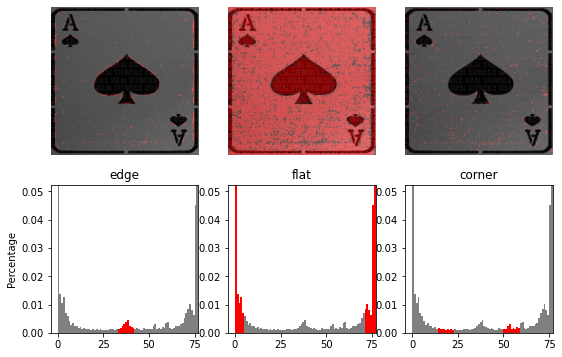

In [17]:
#example of an LBP representation of an image
# settings for LBP
radius = 5
n_points = 15 * radius
METHOD = 'uniform'

image = cv2.imread(train_df.filepaths.iloc[15])
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
lbp = local_binary_pattern(gray_image, n_points, radius, METHOD)

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

## PCA - LBP

(5138, 75)


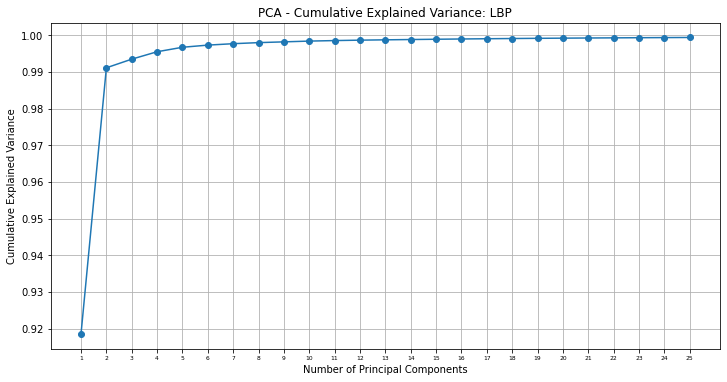

In [18]:
# Perform PCA on the LBP representation

radius = 5
n_points = 15 
METHOD = 'uniform'

num_images = len(train_df.filepaths)

images_lbp = np.zeros((num_images,n_points*radius))
for i, img_path in enumerate(train_df.filepaths):
    lbp_hist = hist_lbp(img_path, n_points = n_points, radius = radius, METHOD = 'uniform' )
    images_lbp[i] =  lbp_hist
pca = PCA(n_components = 25)
images_lbp_pca = pca.fit_transform(images_lbp)
print((images_lbp.shape))

# Cumulative explained variance.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of principal components to plot with increments of 100.
num_components = 25 #hog_hue_features_pca.shape[1]
components_range = np.arange(1, num_components + 1, 1)

plt.figure(figsize=(12, 6))
plt.plot(components_range, cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance: LBP')
plt.xticks(components_range, fontsize=6)
plt.grid(True)
plt.show()

## TSNE for LBP

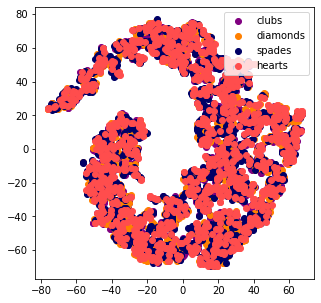

In [19]:
tsne = TSNE(n_components=2, random_state=1)
X = tsne.fit_transform(images_lbp)
y = ['clubs','diamonds','spades','hearts']

plt.figure(figsize=(5,5))

viridis = cm.get_cmap('viridis')

for i in y:
    if i == 'hearts':
        color = (1, 0.3, 0.3)  # Lighter red for hearts
    elif i == 'diamonds':
        color = (1, .5, 0)  # Slightly lighter red for diamonds
    elif i == 'clubs':
        color = (0.5, 0, 0.5)  # lighter gray for clubs
    else:
        color = (0, 0, 0.4)  # Slightly darker black for spades
    
    plt.scatter( X[train_df.suit == i,0],
               X[train_df.suit == i, 1],
               color = color, label = i)
plt.legend()

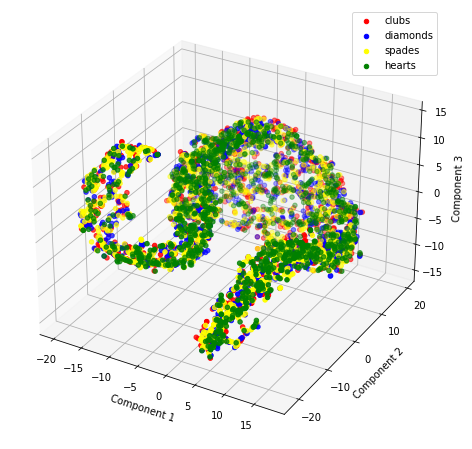

In [25]:
tsne = TSNE(n_components=3, random_state=1)
X = tsne.fit_transform(images_lbp)
y = ['clubs', 'diamonds', 'spades', 'hearts']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

viridis = cm.get_cmap('viridis')
colors = np.linspace(0, 1, 4)
for i in y:
    if i == 'hearts':
        color = 'green'  
    elif i == 'diamonds':
        color = 'blue'  
    elif i == 'clubs':
        color = 'red'  
    else:
        color = 'yellow'  

    ax.scatter(X[train_df.suit == i, 0],
               X[train_df.suit == i, 1],
               X[train_df.suit == i, 2],  # Use the third dimension for plotting
               color=color, label=i)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.show()


## Average LBP representation by suit

In [21]:
num_images = len(train_df.filepaths)
lbp_array = np.zeros((224,224,4,num_images))
suit_labels = set(train_df.suit)
radius = 5
n_points = 15 * radius
METHOD = 'uniform'
dict_suits = {'spades':0, 'hearts':1, 'diamonds':2,'clubs':3}

for j,img_path in enumerate(train_df.filepaths):
    suit = train_df.iloc[j,]['suit']
    image = cv2.imread(img_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, n_points, radius, METHOD)
    suit_index = dict_suits[suit]
    lbp_array[:,:,suit_index,j] = lbp
    

In [22]:
lbp_array

array([[[[75.,  0., 76., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  2.,  2.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 19.,  0., ...,  0.,  0.,  6.]],

        [[75.,  0.,  7., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  4.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 76.,  0., ...,  0.,  0.,  6.]],

        [[25.,  0.,  1., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  5.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 76.,  0., ...,  0.,  0.,  0.]],

        ...,

        [[75.,  0., 76., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0., 22.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 24.,  0., ...,  0.,  0.,  0.]],

        [[75.,  0., 76., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0., 10.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 21.,  0., ...,  0.,  0., 76.]],

        [[75.,  0., 19., ...,  0.,  0.,  0.],
         [

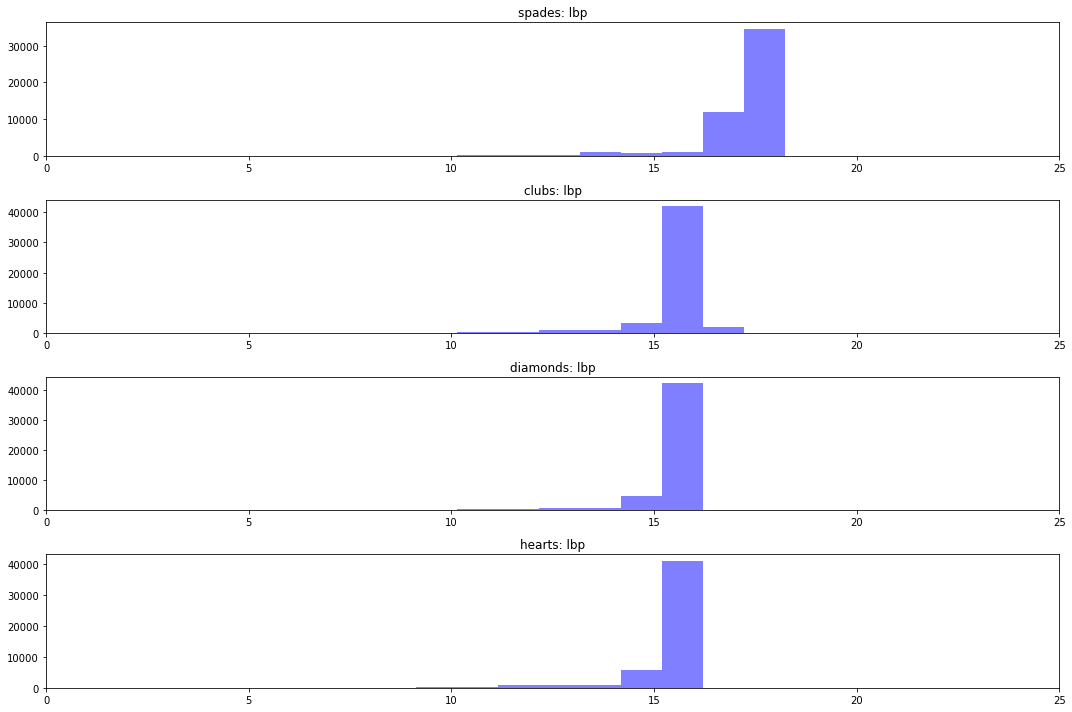

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
average_lbp = np.zeros((224,224))

for j, item in enumerate(suit_labels):
    average_lbp = np.mean(lbp_array,axis = 3)[:,:,j]
    ax[j].hist(average_lbp.flatten(), bins=75, range=(0, 76), color='blue', alpha=0.5)
    ax[j].set_title(item + ': lbp')
    ax[j].set_xlim([0, 25])

plt.tight_layout()
plt.show()